In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import camb
import os
from classy import Class # import classy module

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=24)
rc('axes', labelsize=20)
rc('axes', axisbelow=False)
rc('lines',linewidth=2)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
rc('legend',fontsize='x-large')

#################################

# unfortunately autodiff currently needs double precision!
jax.config.update("jax_enable_x64", True) 
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)

from pylinger_background import evolve_background
from pylinger_perturbations import evolve_one_mode, evolve_perturbations

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
# OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.00
cs2_DE  = 0.99
mnu     = 0.06  #eV
Neff    = 3.046 # -1 if massive neutrino present
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
H0      = 67.742
A_s     = 2.1064e-09
n_s     = 0.96822
kmin    = 1e-4
kmax    = 1e+1
num_k   = 256

aexp = jnp.geomspace(1e-5,1,256)

# list of parameters with respect to which we take derivatives
fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'Y_{He}', 'A_s', 'n_s', 'w_0', '(1+w_a)', 'c_a^2']
fiducial_cosmo_param = jnp.array([H0, Omegam, Omegab, N_nu_rel, mnu, Tcmb, YHe, A_s, n_s,  w_DE_0, 1+w_DE_a, cs2_DE])


In [4]:
def Pk_of_cosmo( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    param = {}
    param['Omegam']  = args[1]
    param['Omegab']  = args[2]
    param['OmegaDE'] = 1-args[1]
    param['Omegak']  = 0.0
    param['A_s']     = args[7]
    param['n_s']     = args[8]
    param['H0']      = args[0]
    param['Tcmb']    = args[5]
    param['YHe']     = args[6]
    param['Neff']    = args[3]
    param['Nmnu']    = 1 #N_nu_mass
    param['mnu']     = args[4]
    param['w_DE_0']  = args[9]
    param['w_DE_a']  = args[10]-1
    param['cs2_DE']  = args[11]

    param['k_p']    = 0.05

    ## compute the background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')
    

    # Compute Perturbations
    # lmaxg  = 12
    # lmaxgp = 12
    # lmaxr  = 17
    # lmaxnu = 17
    # nqmax  = 15

    rtol   = 1e-6
    atol   = 1e-6
    max_steps = 4096

    # Compute Perturbations
    # nmodes = 256  # number of modes to compute, reduce to speed up calculation
    # kmin = 1e-4
    # kmax = 1e1
    # aexp_out = jnp.array([1.0])
    aexp_out = jnp.copy(aexp) #jnp.geomspace(1e-3,1,256)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=num_k, aexp_out=aexp_out,
                                    ##  lmaxg=lmaxg, lmaxgp=lmaxgp, lmaxr=lmaxr, lmaxnu=lmaxnu, nqmax=nqmax,
                                        lmaxg = 31, lmaxgp = 31, lmaxr = 31, lmaxnu = 31, nqmax = 5,
                                        # lmaxg = 17, lmaxgp = 17, lmaxr = 17, lmaxnu = 17, nqmax = 5,
                                       rtol=rtol, atol=atol, max_steps=max_steps )

    # iout = -1
    fac = 2 * jnp.pi**2 * A_s
    # Pkm = fac *(kmodes[:,None]/k_p)**(n_s - 1) * kmodes[:,None]**(-3) * y[:,:,4]**2   #total matter = cdm + baryon + massive neutrino
    Pkbc = 2 * jnp.pi**2 * param['A_s'] *(kmodes[:,None]/param['k_p'])**(param['n_s'] - 1) * kmodes[:,None]**(-3) * y[...,6]**2
    return Pkbc
    # Pkbc = fac *(kmodes[:,None]/k_p)**(n_s - 1) * kmodes[:,None]**(-3) * y[:,:,6]**2
    # return Pkbc

In [5]:
def Pk_CAMB( args ):
  os.environ["OMP_NUM_THREADS"] = "8"
  # ## CAMB setup
  h = args[0] / 100.
  Omegab = args[2]
  # use DISCO-EB module to get massive neutrino density
  param = {}
  param['Omegam']  = args[1]
  param['Omegab']  = args[2]
  param['OmegaDE'] = 1-args[1]
  param['Omegak']  = 0.0
  param['A_s']     = args[7]
  param['n_s']     = args[8]
  param['H0']      = args[0]
  param['Tcmb']    = args[5]
  param['YHe']     = args[6]
  param['Neff']    = args[3]
  param['Nmnu']    = N_nu_mass
  param['mnu']     = args[4]
  param['w_DE_0']  = args[9]
  param['w_DE_a']  = args[10]-1
  param['cs2_DE']  = args[11]

  param['k_p']  = 0.05

  ## compute the background evolution
  param = evolve_background(param=param, thermo_module='RECFAST')
  # param = evolve_background(param=param, thermo_module='MB95')
  Omeganu = param['Omegamnu']
  g = (Tnu / (11/4)**(-1/3))**4 # 11/4 is g_0/g_*
  Omegac = args[1] - Omegab
  YHe = args[6]
  Tcmb = args[5]
  Neff = args[3]
  num_massive_neutrinos = 1
  w_DE_0 = args[9]
  w_DE_a = args[10] - 1
  cs2_DE = args[11]
  A_s = args[7]
  n_s = args[8]
  pars = camb.CAMBparams(H0=100*h, ombh2=Omegab*h**2, omch2=Omegac*h**2, omnuh2=Omeganu*h**2, omk=0.0, YHe=YHe, TCMB=Tcmb, 
                          num_nu_massive=N_nu_mass, num_nu_massless=Neff, nu_mass_eigenstates = 1,
                          nu_mass_fractions=[1.], nu_mass_degeneracies=[g * N_nu_mass], nu_mass_numbers=[1], share_delta_neff=False )
                          # nu_mass_numbers=[nnu], nu_mass_degeneracies=[Neff / nnu],
                          # nu_mass_fractions=[1.], share_delta_neff=True)
                        #num_nu_massive=num_massive_neutrinos, num_nu_massless=Neff)
  #This function sets up with one massive neutrino and helium set using BBN consistency
  # pars.set_cosmology(H0=100*h, ombh2=Omegab*h**2, omch2=(Omegam-Omegab)*h**2, mnu=mnu, omk=0., 
  #                    tau=None, num_massive_neutrinos=num_massive_neutrinos, standard_neutrino_neff = Neff+num_massive_neutrinos,
  #                    nnu=Neff+num_massive_neutrinos, YHe=YHe, TCMB=Tcmb )
  pars.set_dark_energy(w=w_DE_0, cs2=cs2_DE, wa=w_DE_a, dark_energy_model='fluid')
  pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
  pars.set_accuracy(AccuracyBoost=2.0 , DoLateRadTruncation=False, lAccuracyBoost=2.0 )
  pars.set_matter_power(redshifts=[0.0], kmax=kmax/h*1.001, accurate_massive_neutrino_transfers=True)
  pars.Reion.Reionization = False
  pars.Transfer.high_precision = True
  pars.Transfer.accurate_massive_neutrinos = True
  results = camb.get_results(pars)
  kh_camb, z_camb, pkbc_camb = results.get_matter_power_spectrum(minkh=kmin/h, maxkh=kmax/h, npoints = num_k, var1='delta_nonu', var2='delta_nonu')
  return pkbc_camb / h**3

In [25]:
def Pk_CLASS( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    # CLASS setup
    # create instance of the class "Class"
    LambdaCDM = Class()
    # pass input parameters
    LambdaCDM.set({
        'Omega_k':  0.0,
        'Omega_b':  args[2],
        'Omega_cdm':args[1]-args[2],
        'N_ur':     args[3],
        'N_ncdm':   N_nu_mass,
        'm_ncdm':   args[4],
        'T_ncdm':   Tnu,
        'h':        args[0]/100,
        'A_s':      args[7],
        'n_s':      args[8],
        # 'tau_reio':0.06, 
        'gauge':    'synchronous',
        'reio_parametrization' : 'reio_none',
        'recombination' : 'RECFAST',
        'k_per_decade_for_pk' : 64,
        'k_per_decade_for_bao' : 64,
        # 'compute damping scale' : 'yes',
        'tol_perturbations_integration' : 1e-07,
        'tol_background_integration' : 1e-07,
        # # 'hyper_flat_approximation_nu' : 7000,
        'T_cmb':    args[5],
        'YHe':      args[6],
        'output':   'mPk',
        'lensing':  'no',
        'P_k_max_1/Mpc': kmax*1.01,
        'z_max_pk': 1000.0,
        # # these are high precision reference settings
        # 'start_small_k_at_tau_c_over_tau_h' : 0.0004,
        # 'start_large_k_at_tau_h_over_tau_k' : 0.05,
        # 'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
        # 'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
        # 'start_sources_at_tau_c_over_tau_h' : 0.006,
        # 'l_max_g' : 50,
        # 'l_max_pol_g' : 25,
        # 'l_max_ur' : 50,
        # 'l_max_ncdm' : 50,
        'Omega_Lambda' : 0.0,
        'w0_fld' : args[9],
        'wa_fld' : args[10]-1,
        'cs2_fld' : args[11],
        'l_max_g' : 31,
        'l_max_pol_g' : 31,
        'l_max_ur' : 31,
        'l_max_ncdm' : 31,
        'use_ppf' : 'no',
        # 'radiation_streaming_approximation' : 3,
        'ncdm_fluid_approximation' : 3,
        # 'ur_fluid_approximation' : 3,
      })
    # run class
    LambdaCDM.compute()
    zout = 0.0
    # Pkm_CLASS = np.array([LambdaCDM.pk_lin(ki, zout) for ki in np.geomspace(kmin,kmax,num_k)])
    Pkm_CLASS = np.array([LambdaCDM.pk_cb_lin(ki, zout) for ki in np.geomspace(kmin,kmax,num_k)])
    return Pkm_CLASS

In [7]:

# # @eqx.filter_jit
# def fonek_of_Omegam( args, kmode ):
#     """
#     args:
#         0: Omegam
#         1: Omegab
#         2: A_s
#         3: n_s
#         4: H0
#         5: Tcmb
#         6: YHe
#         7: Neff
#         8: mnu
#     """
#     A_s = args[2]
#     n_s = args[3]
#     param = {}
#     param['Omegam'] = args[0]
#     param['Omegab'] = args[1]
#     param['OmegaL'] = 1-param['Omegam']
#     param['Omegak'] = 0.0
#     param['A_s'] = args[2]
#     param['n_s'] = args[3]
#     param['H0'] = args[4]
#     param['Tcmb'] = args[5]
#     param['YHe'] = args[6]
#     param['Neff'] = args[7]
#     param['Nmnu'] = 1
#     param['mnu'] = args[8]
#     param = evolve_background(param=param)
    
#     k = 1e-2

#     # Compute Perturbations
#     # lmaxg  = 12
#     # lmaxgp = 12
#     # lmaxr  = 17
#     # lmaxnu = 17
#     # nqmax  = 15

#     # rtol   = 1e-4
#     # atol   = 1e-4

#     # Compute Perturbations
#     # aexp_out = jnp.array([1e-2,1e-1]) 
#     aexp_out = jnp.geomspace(1e-5,1,128)
#     tau_out = jax.vmap( lambda a: param['tau_of_a_spline'].evaluate(a) )(aexp_out)

#     y = evolve_one_mode( param=param, kmode=kmode, tau_out=tau_out, tau_max=jnp.max(tau_out) )

#     k = kmode
#     return A_s*(k/k_p)**(n_s - 1) * k**(-3) * y**2 

In [8]:
## compute the jacobian 
k  = jnp.geomspace(kmin,kmax,num_k) # number of modes to compute, reduce to speed up calculation

dy = jax.jacfwd(Pk_of_cosmo)(fiducial_cosmo_param)
y  = Pk_of_cosmo( fiducial_cosmo_param )

In [26]:
def get_finite_difference_class( idx, feps=1e-3 ):
  eps = feps * fiducial_cosmo_param[idx]
  param_plus  = np.copy(fiducial_cosmo_param)
  param_plus[idx] += eps/2
  param_minus = np.copy(fiducial_cosmo_param)
  param_minus[idx] -= eps/2

  Pk_minus = Pk_CLASS( param_minus )
  Pk_plus = Pk_CLASS( param_plus )

  return (np.log(Pk_plus/Pk_minus))/(np.log(param_plus[idx]/param_minus[idx]))

dy_fd0 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )
# dy_fd1 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )
# dy_fd2 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )

for i in range( len(fiducial_cosmo_param) ):
  dy_fd0[:,i] = get_finite_difference_class( i, 1e-3 )
  # dy_fd1[:,i] = get_finite_difference_class( i, 1e-3 )
  # dy_fd2[:,i] = get_finite_difference_class( i, 1e-4 )


In [10]:
def get_finite_difference_camb( idx, feps=1e-3 ):
  eps = feps * fiducial_cosmo_param[idx]
  param_plus  = np.copy(fiducial_cosmo_param)
  param_plus[idx] += eps/2
  param_minus = np.copy(fiducial_cosmo_param)
  param_minus[idx] -= eps/2

  Pk_minus = Pk_CAMB( param_minus )
  Pk_plus = Pk_CAMB( param_plus )

  return (np.log(Pk_plus/Pk_minus))/(np.log(param_plus[idx]/param_minus[idx]))

dy_fd0camb = np.zeros( (num_k, len(fiducial_cosmo_param) ) )
# dy_fd1camb = np.zeros( (num_k, len(fiducial_cosmo_param) ) )
# dy_fd2 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )

for i in range( len(fiducial_cosmo_param) ):
  dy_fd0camb[:,i] = get_finite_difference_camb( i, 1e-2 )
  # dy_fd1camb[:,i] = get_finite_difference_camb( i, 1e-3 )
  # dy_fd2[:,i] = get_finite_difference_class( i, 1e-4 )


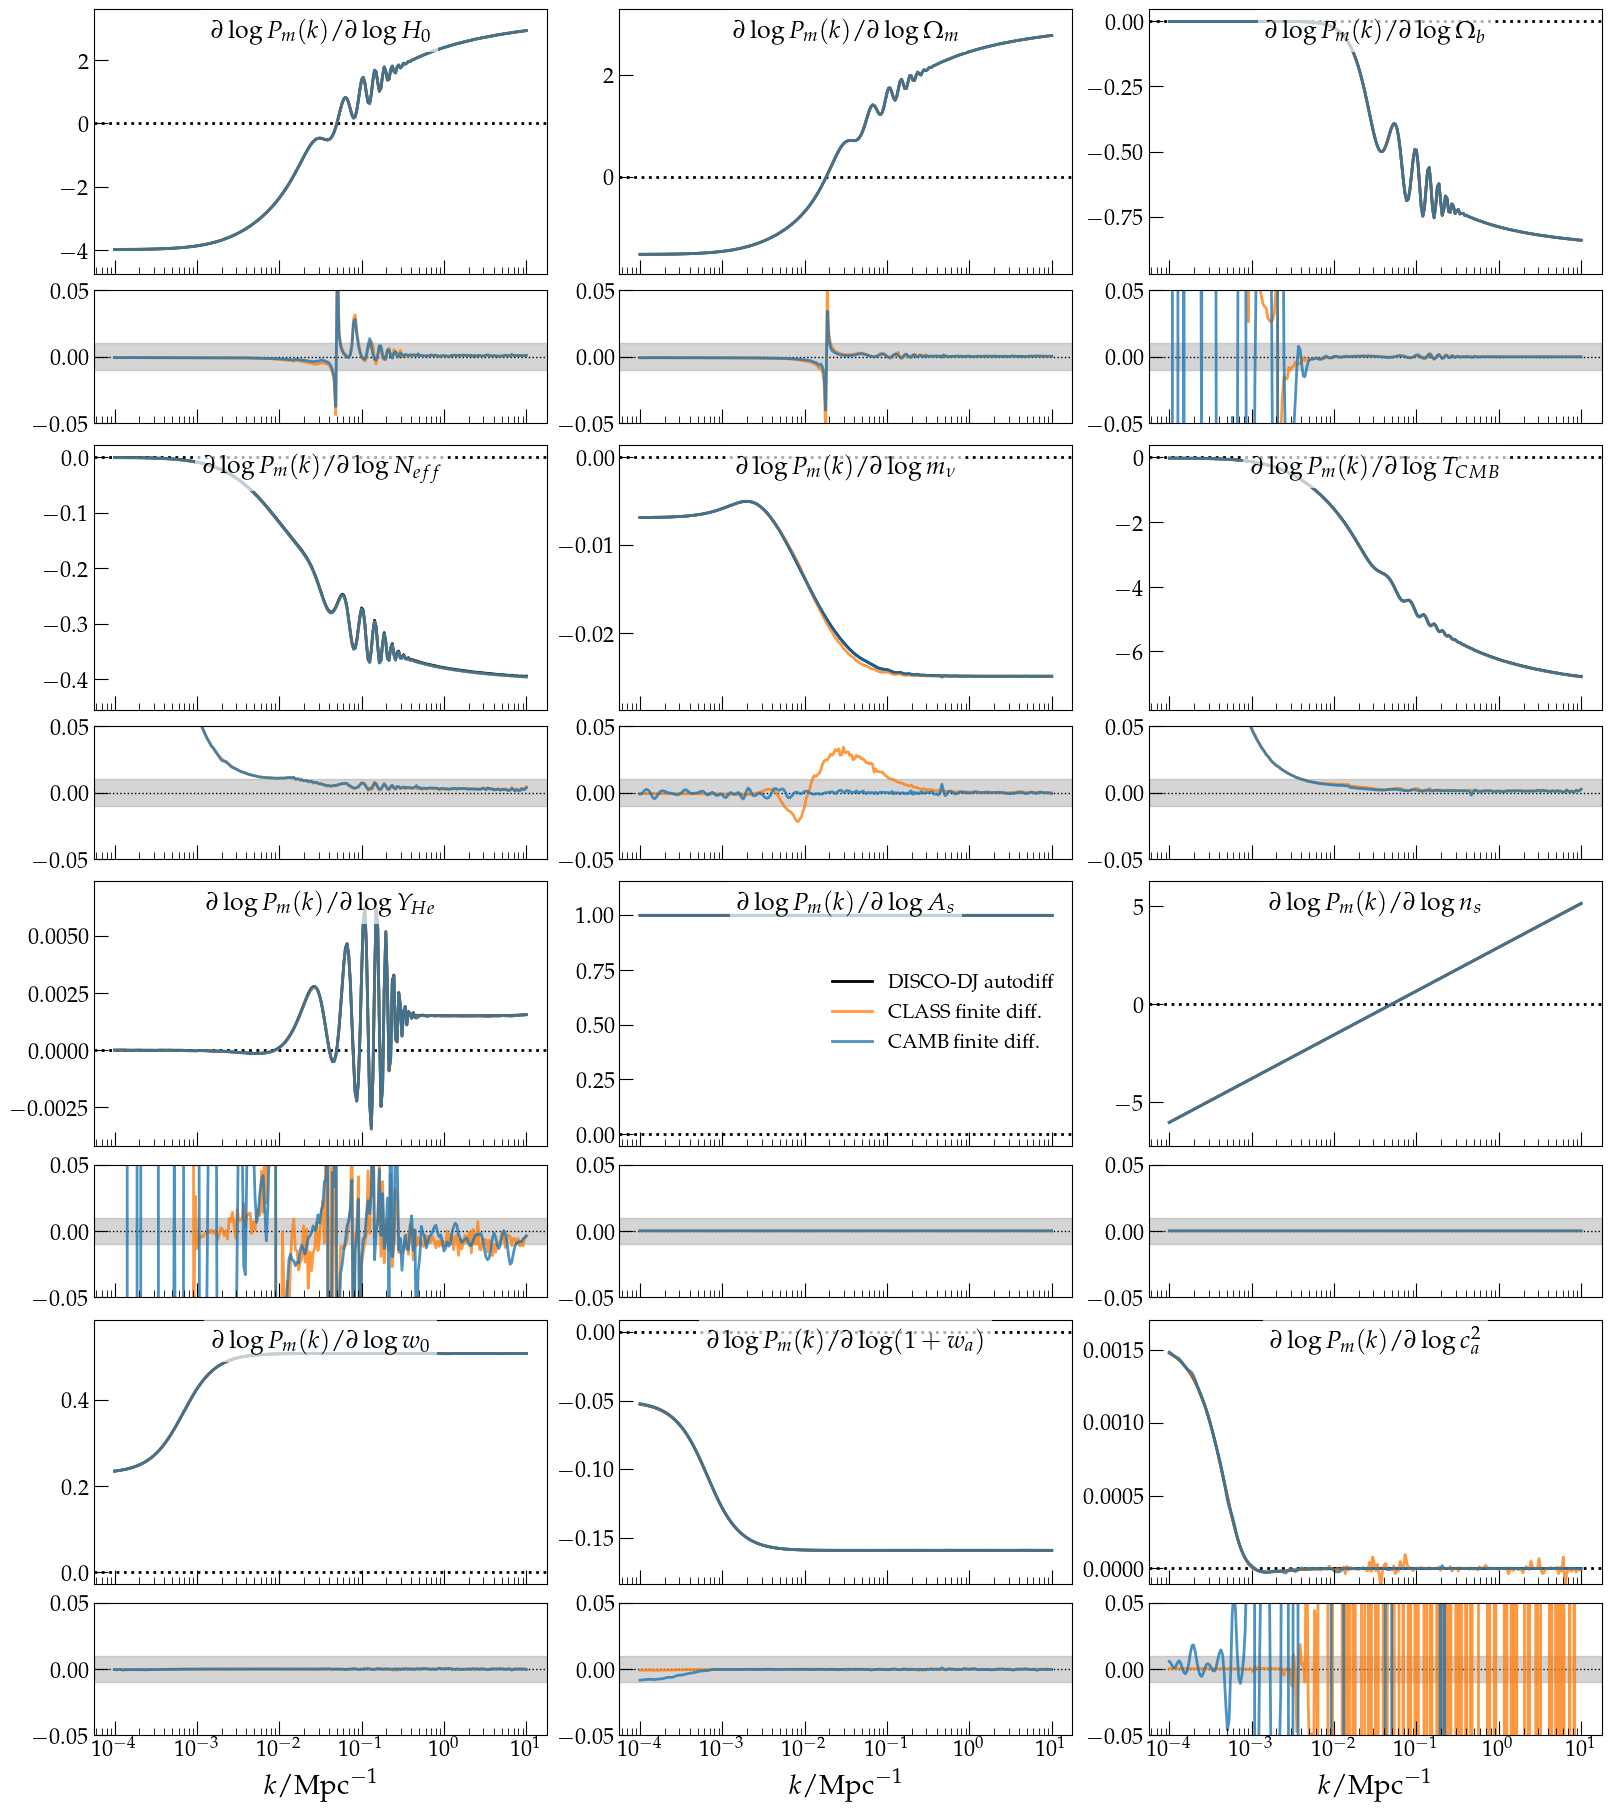

In [22]:
## make the plot
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(8,3,sharex=True,figsize=(16,18),layout='constrained', gridspec_kw={'height_ratios': [2,1,2,1,2,1,2,1]})

title_bbox = dict(boxstyle="square", edgecolor="none", facecolor="white", alpha=0.667)



for i,ff in enumerate(fieldnames):
    iy = i%3
    ix = i//3
    dlogy = dy[:,-1,i]/y[:,-1]

    ax[2*ix,iy].axhline(0.0, ls=':', color='k', label='_nolegend_')
    
    ax[2*ix,iy].semilogx(k, fiducial_cosmo_param[i] * dlogy, label='$P_{m}$',c='k',lw=2)
    ylim = ax[2*ix,iy].get_ylim()

    ax[2*ix,iy].semilogx(k, dy_fd0[:,i],label='$P_{m}$',c='C1',ls='-',lw=2,alpha=0.8)
    ax[2*ix,iy].semilogx(k, dy_fd0camb[:,i],label='$P_{m}$',c='C0',ls='-',lw=2,alpha=0.8)
    ax[2*ix,iy].set_ylim(ylim[0]*1.1,ylim[1]*1.1)
    ax[2*ix,iy].set_title(f'$\\partial \\log P_{{m}}(k) / \\partial \\log {ff}$', bbox=title_bbox, fontsize=18)

    ax[2*ix+1,iy].axhline(0.0,ls=':',c='k',lw=1)
    ax[2*ix+1,iy].semilogx(k, dy_fd0[:,i]/dlogy/fiducial_cosmo_param[i]-1.0, lw=2, ls='-', c='C1',alpha=0.8)
    
    ax[2*ix+1,iy].semilogx(k, dy_fd0camb[:,i]/dlogy/fiducial_cosmo_param[i]-1.0, lw=2, ls='-', c='C0',alpha=0.8)
    ax[2*ix+1,iy].set_ylim(-0.05,0.05)
    ax[2*ix+1,iy].axhspan(-0.01, 0.01, alpha=0.33, color='gray')
    
for a in ax[-1,:]:
    a.set_xlabel('$k / \\mathrm{Mpc}^{-1}$')

ax[4,1].legend(['DISCO-DJ autodiff','CLASS finite diff.','CAMB finite diff.'],frameon=False)
plt.savefig('derivatives_parameters.pdf')

In [23]:

def plot_tile( ax, kmodes, aexp, dlogy, title ):
  
  cc = np.max(np.abs(dlogy)[~np.isnan(np.abs(dlogy))])

  im = ax.pcolormesh( kmodes, aexp, dlogy.T, edgecolors='face', cmap='RdBu_r', vmin=-cc, vmax=cc, shading='auto', rasterized=True )

  cbar = plt.colorbar(im, ax=ax, shrink=0.7)
  cbar.ax.tick_params(labelsize=10)
  
  ax.set_zorder(1)
  ax.patch.set_alpha(0.0)
  
  ax.loglog()
  ax.set_xlim(kmin,kmax)
  ax.set_ylim(np.min(aexp),np.max(aexp))
  ax.invert_yaxis()
  
  title_bbox = dict(boxstyle="square", edgecolor="none", facecolor="white", alpha=0.667)
  # title_bbox = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.667)
  ax.set_title( title, bbox=title_bbox, fontsize=18)
  # newax.set_position( ax.get_position() )

  return im

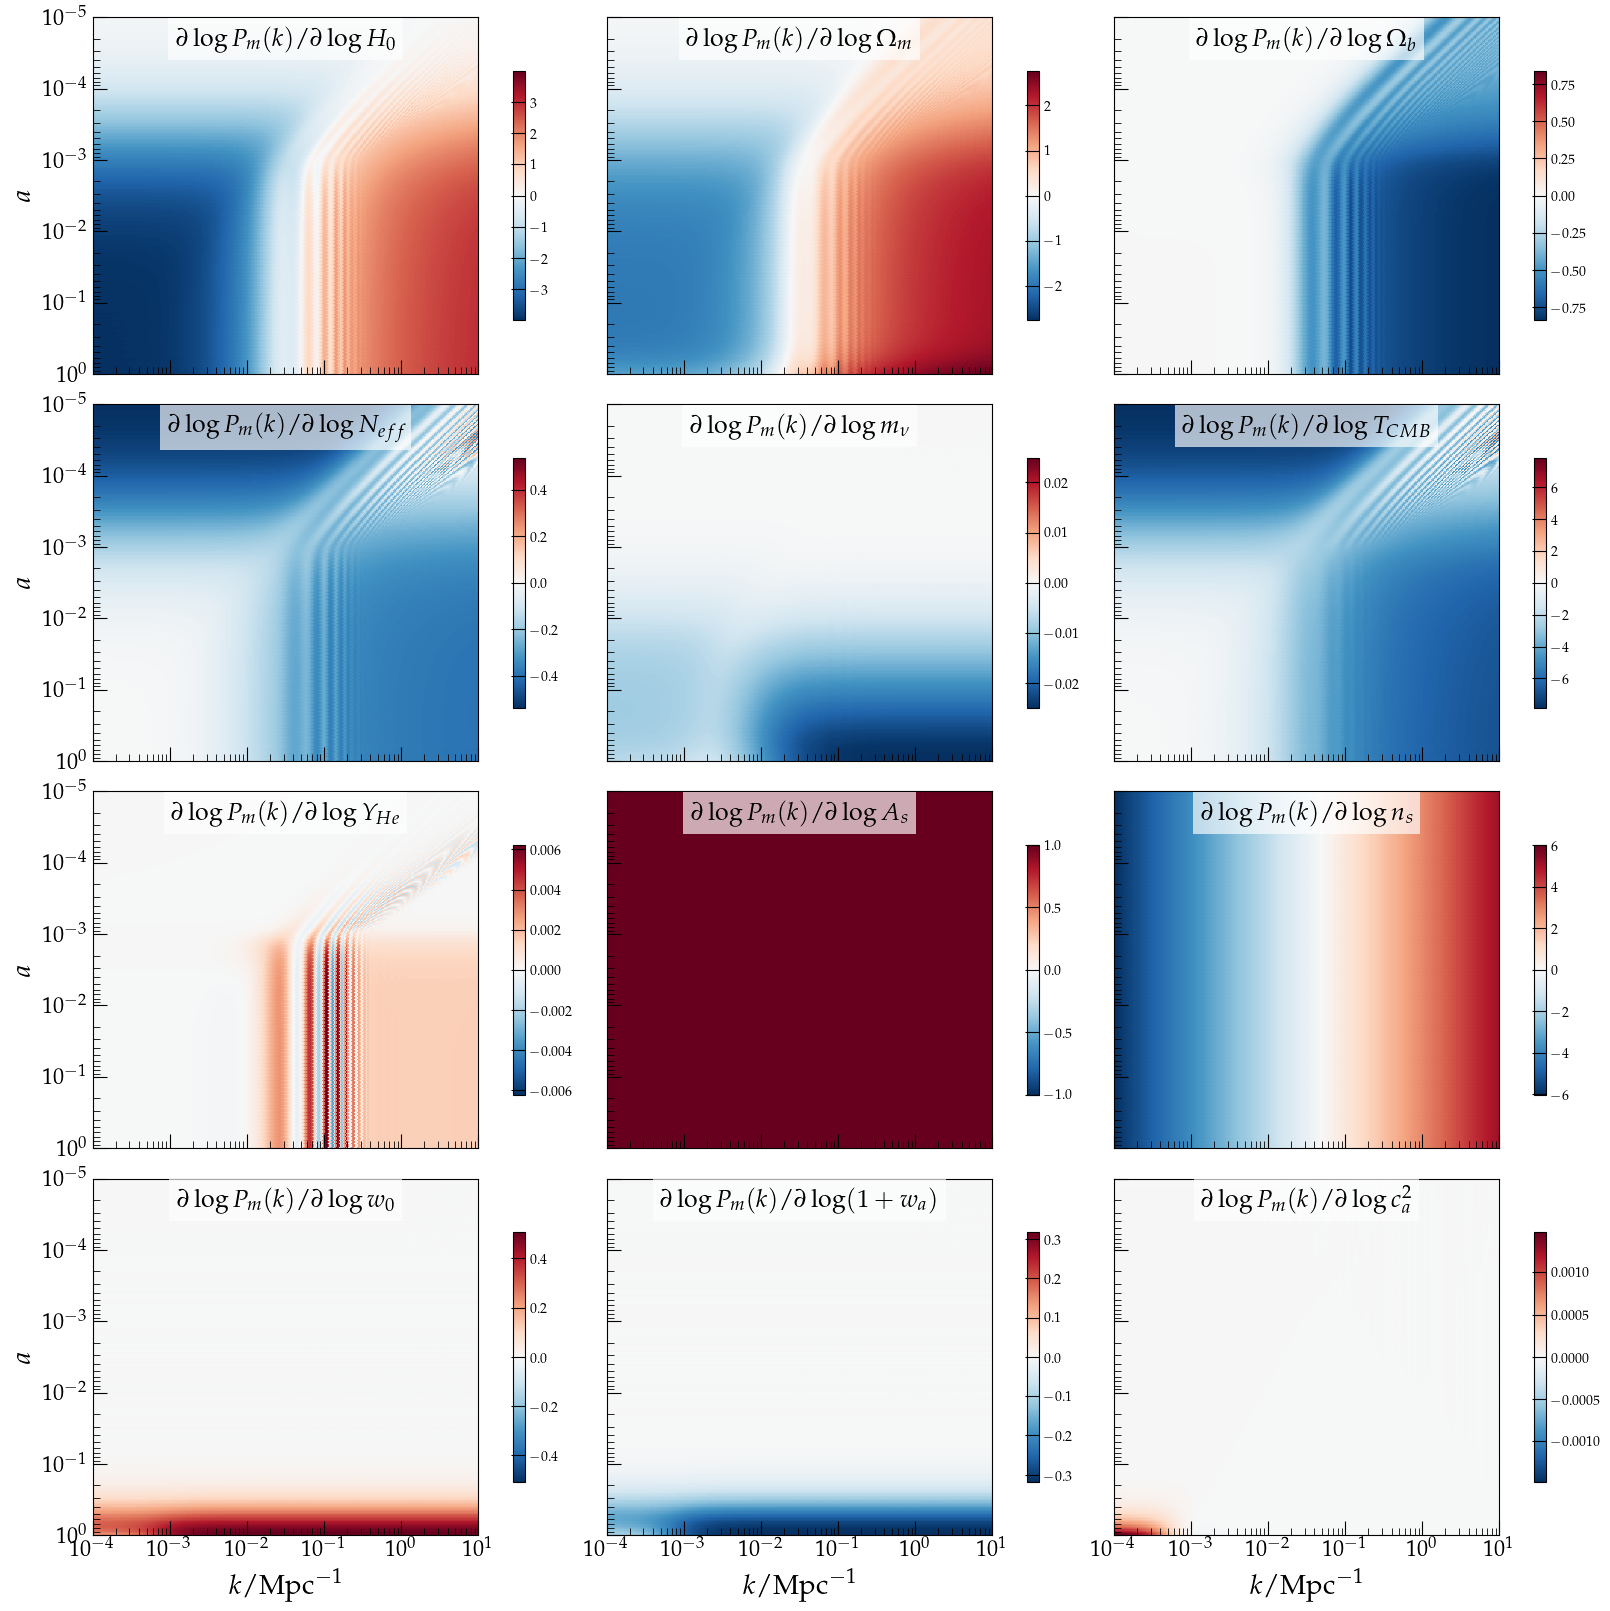

In [24]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(4,3,sharex=True,sharey=True,figsize=(16,16),layout='constrained')

m = np.zeros_like(ax)
ims = np.zeros_like(ax)
for i,ff in enumerate(fieldnames):
    iy = i%3
    ix = i//3
    if i in [10,]:
        dlogy = (1+fiducial_cosmo_param[i])*dy[...,i]/y
    else:
        dlogy = fiducial_cosmo_param[i]*dy[...,i]/y

    ims[ix,iy] = plot_tile( ax[ix,iy], k, aexp, dlogy, f'$\\partial \\log P_{{m}}(k) / \\partial \\log {ff}$')

for a in ax[-1,:]:
    a.set_xlabel('$k / \\mathrm{Mpc}^{-1}$')


for a in ax[:,0]:
    a.set_ylabel('$a$')

for a in ax.flatten():
    a.set_ylim(np.max(aexp), np.min(aexp))

# fig.canvas.draw()

# for aa,mm in zip(ax.flatten(),m.flatten()):
#     mm.set_position( aa.get_position(original=False), which='active' )
#     mm.set_position( aa.get_position(original=True), which='original' )

# ims[2,1].set_clim(-1,1)
plt.savefig('derivatives_spacetime.pdf')

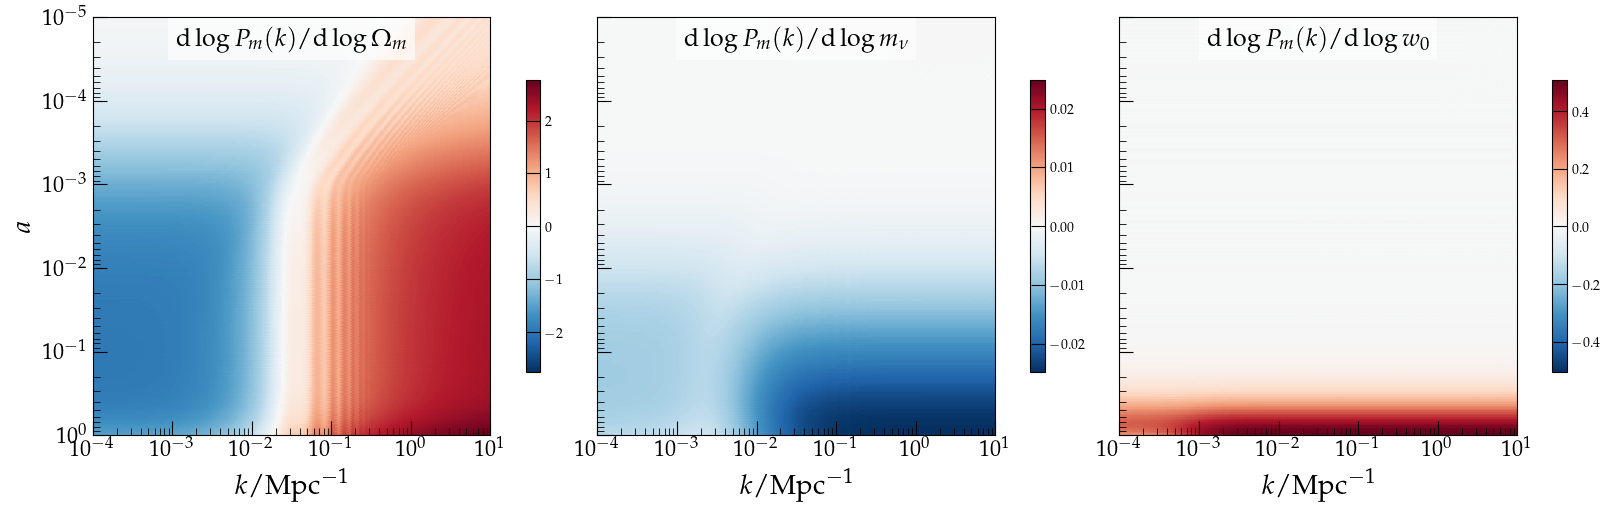

In [14]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(16,5),layout='constrained')

m = np.zeros_like(ax)
ims = np.zeros_like(ax)
for i,(ii,ff) in enumerate([(i,fieldnames[i]) for i in [1,4,9]]):
    iy = i%3
    ix = i//3
    
    dlogy = fiducial_cosmo_param[ii]*dy[...,ii]/y
    
    ims[iy] = plot_tile( ax[iy], k, aexp, dlogy, f'$\\mathrm{{d}} \\log P_{{m}}(k) / \\mathrm{{d}} \\log {ff}$')

for a in ax[:]:
    a.set_xlabel('$k / \\mathrm{Mpc}^{-1}$')

ax[0].set_ylabel('$a$')

for a in ax.flatten():
    a.set_ylim(np.max(aexp), np.min(aexp))

# fig.canvas.draw()

# for aa,mm in zip(ax.flatten(),m.flatten()):
#     mm.set_position( aa.get_position(original=False), which='active' )
#     mm.set_position( aa.get_position(original=True), which='original' )

# ims[2,1].set_clim(-1,1)
plt.savefig('derivatives_spacetime_subset.pdf')